# S1 Multiplicity
.... background and bullshit

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-03 11:02:08


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math

In [5]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [6]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from invisible_cities.core.configure import configure, print_configuration

from invisible_cities.core.system_of_units_c import units
from invisible_cities.cities.base_cities import PmapCity, SensorParams
from invisible_cities.cities.base_cities import S12Params as S12P

In [7]:
from invisible_cities.core.core_functions import define_window
from invisible_cities.core.core_functions import lrange
from collections import namedtuple

In [8]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps,\
                                         SensorParams, CalibParams, PmapParams, CalibratedPMT, S1PMaps

In [9]:
from matplotlib.figure import Figure

In [10]:
%load_ext Cython

In [11]:
from event_pmaps import compare_S1_ext

### Input

In [12]:
run_number=3389
#run_number=0

In [13]:
ic_data = os.path.join(os.environ['IC_DATA'])
files  = glob(ic_data + 'LSC/' + str(run_number) + '/' +  'dst_waves.gdcsnext.*_3389.root.h5')
#files  = [ic_data + 'Montecarlo/' + 'dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_RWF_10000.root.h5']

In [14]:
print(files)

['/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.000_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.001_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.002_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.003_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.004_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.005_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.006_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.007_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.008_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.009_3389.root.h5']


### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [15]:
def _calib_vectors(self):
        """Provisional fix for calib vectors"""
        channel_id = np.array([0,1,4,5,8,18,22,23,26,27,30])
        coeff_blr = np.array([1.61,1.62,1.61,1.61,1.61,
                          0.8,0.8,0.8,0.8,0.8,1.60,
                          1.0]) * 0.001
        coeff_c = np.array([2.94,2.75,3.09,2.81,2.88,
                        1.,1.,1.,1.,1.,2.76,
                        1.0]) * 1e-6
        adc_to_pes = np.array([25.17,22.15,33.57,23.88,21.55,
                           26.49,25.39,27.74,23.78,20.83,26.56,
                           0.])
        pmt_active = list(range(11))

        DataSiPM = load_db.DataSiPM()
        self.P   = CalibVectors(channel_id = channel_id,
                                coeff_blr  = coeff_blr,
                                coeff_c    = coeff_c,
                                adc_to_pes_pmt = adc_to_pes,
                                adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                                pmt_active  = pmt_active)

### S1 multiplicity

In [16]:
DataPMT = load_db.DataPMT(run_number)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c    = abs(DataPMT.coeff_c.values)
coeff_blr  = abs(DataPMT.coeff_blr.values)
DataSiPM   = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [17]:
def charge_and_position(s2si):
        """
        Charge and position from S2Si
        """
        xsipm = []
        ysipm = []
        Q = []
        
        for key, value in s2si.items():
            xsipm.append(xs[key])
            ysipm.append(ys[key])
            Q.append(np.sum(value))
        return np.array(xsipm), np.array(ysipm), np.array(Q)

In [21]:
multiplicity = []
energies = []

Ms = []

no_m_ev = []
#no_m_s1 = []

s2_info = []
s2_info_m1 =[]

for f in files:
    
    with tb.open_file(f, 'r') as h5rwf:

        print(h5rwf.root.Sensors.DataPMT[:]['sensorID'])

        pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
        NEVT, NPMT, PMTWL = pmtrwf.shape
        NEVT, NSIPM, SIPMWL = sipmrwf.shape
        
        #print(str(NEVT) + ' in: ' + f + '... ')

        for event in range(NEVT):
            #if len(energies) >= 1500: break

            # Get cwf csum_mau
            RWF = pmtrwf[event]
            CWF = blr.deconv_pmt(RWF,
                                 coeff_c,
                                 coeff_blr,
                                 pmt_active,
                                 n_baseline  = 48000,
                                 thr_trigger = 5)

            CAL_PMT, CAL_PMT_MAU = cpf.calibrated_pmt_mau(
                                   CWF,
                                   adc_to_pes,
                                   pmt_active = pmt_active,
                                   n_MAU   = 100,
                                   thr_MAU =   3)
            csum, csum_mau = cpf.calibrated_pmt_sum(CWF,adc_to_pes, pmt_active)

            # Find s1s ## SET tmin and tmax appropriately!!
            s1par = S12Params(tmin=0*units.mus, 
                              tmax=640*units.mus, 
                              lmin=6, lmax=40, 
                              stride=4, rebin=False)
            s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.5)        
            
            try:
                S1 = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
            except IndexError:
                if s1_ene != 0 or s1_indx !=0: 
                    print(s1_ene, s1_indx, **s1par._asdict())
                    raise
            
            # Will discard evts with multiple S1s
            if len(S1) != 1: continue

            # (there can pe multiple S1s in each event)
            for nums1, s_1 in enumerate(S1):

                t_buffer = 50 * units.ns
                # Set up params for searching individual pmt cal mau waveforms
                s1par  = S12Params(tmin=(S1[s_1][0][ 0] - t_buffer), 
                                   tmax=(S1[s_1][0][-1] + t_buffer), 
                                   lmin=3, 
                                   lmax=40, 
                                   stride=4, 
                                   rebin=False)

                # Dict for storing individual pmt s1s
                PMT_S1 = {}      
                for pmt in pmt_active:

                    # See if there is a corresponding S1 in this PMT
                    s1_ene, s1_indx = cpf.wfzs(CAL_PMT_MAU[pmt], threshold=0.1)
                    try:
                        PMT_S1[pmt] = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
                    except IndexError:
                        if len(s1_ene) != 0 and len(s1_indx) != 0: 
                            print(s1_ene, s1_indx, **s1par._asdict())
                            raise

                # Record multiplicity

                
                # find xy pos
                s2_par = S12Params(tmin=640*units.mus, 
                                   tmax=800*units.mus, 
                                   stride=40, lmin=80, lmax=20000, rebin=True)
                s2_ene, s2_indx = cpf.wfzs(csum, threshold=0.5)
                S2              = cpf.find_S12(s2_ene, s2_indx, **s2_par._asdict())
                sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=3.5*units.pes, n_MAU=100)
                SIPM = cpf.select_sipm(sipm)
                S2Si = pf.sipm_s2_dict(SIPM, S2, thr=5*units.pes)
                xsipm, ysipm, Q = charge_and_position(S2Si[0])
                X    = np.average(xsipm, weights=Q) if np.any(Q) else np.nan
                Y    = np.average(ysipm, weights=Q) if np.any(Q) else np.nan
                R    = (X**2 + Y**2)**0.5 if np.any(Q) else np.nan
                Phi  = np.arctan2(Y, X) if np.any(Q) else np.nan
                
                s2_info.append([X,Y,R,Phi])
                    
                if multiplicity[-1].sum() == 1:
                    s2_info_m1.append([X, Y, R, Phi])

                # remember the S1's energy
                energies.append(S1[s_1][1].sum())
                
                # Looking at multiple s1s from same evt is complicated
                break
            
multiplicity = np.array(multiplicity)  

[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]
[ 0  1  2  3  4  5  6  7  8 10 11]


In [22]:
print('Fraction of S1s found by this PMT')
print('---')
Fs1s=[]
for i, s1f in enumerate(multiplicity.T):
    Fs1s.append(s1f.sum() / len(multiplicity))
    print(DataPMT['PmtID'][i], s1f.sum() / len(multiplicity))
    
garbage = multiplicity[np.where(multiplicity.sum(axis=1) < 3)[0]]

print(' ')
print('Fraction of garbage S1s found by this PMT')
print('(Found are ' + str(len(garbage)) + ' garbage S1s)')
print('---')
for i, s1f in enumerate(garbage.T):
    print(DataPMT['PmtID'][i], s1f.sum() / len(garbage))
    
print(' ')
print('Fraction of garbage S1s found by this PMT / Fraction of S1s found by this PMT')
print('---')    
for i, s1f in enumerate(garbage.T):
    print(DataPMT['PmtID'][i], s1f.sum() / len(garbage) / Fs1s[i])


#print(multiplicity.sum(axis=0) / len(multiplicity)), 
#print(pmt_active)
#print(DataPMT['PmtID'][11])

Fraction of S1s found by this PMT
---
PMT1 0.603255340793
PMT3 0.678535096643
PMT2 0.649033570702
PMT4 0.495422177009
PMTC 0.510681586979
PMTB 0.591047812818
PMTA 0.538148524924
PMT9 0.558494404883
PMT8 0.603255340793
PMT6 0.553407934893
PMT5 0.513733468973
 
Fraction of garbage S1s found by this PMT
(Found are 14 garbage S1s)
---
PMT1 0.0714285714286
PMT3 0.0714285714286
PMT2 0.142857142857
PMT4 0.0714285714286
PMTC 0.428571428571
PMTB 0.0
PMTA 0.0714285714286
PMT9 0.214285714286
PMT8 0.142857142857
PMT6 0.0714285714286
PMT5 0.0
 
Fraction of garbage S1s found by this PMT / Fraction of S1s found by this PMT
---
PMT1 0.118405203565
PMT3 0.105268794174
PMT2 0.220107478728
PMT4 0.144177178058
PMTC 0.83921457029
PMTB 0.0
PMTA 0.132730218742
PMT9 0.38368462139
PMT8 0.236810407131
PMT6 0.129070378151
PMT5 0.0


In [23]:
len(multiplicity)

983

Sometimes it is not finding the S1

In [24]:
s2_info    = np.array(s2_info)
s2_info_m1 = np.array(s2_info_m1)

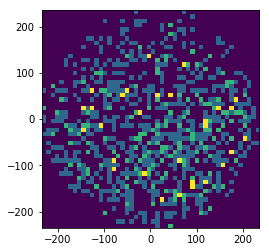

In [27]:
heatmap, xedges, yedges = np.histogram2d(s2_info[:,0], s2_info[:,1], bins=50)
extent = [-235, 235, -235, 235]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

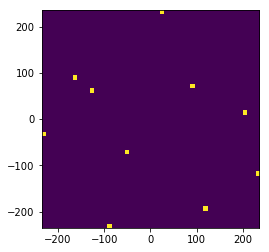

In [28]:
heatmap, xedges, yedges = np.histogram2d(s2_info_m1[:,0], s2_info_m1[:,1], bins=50)
extent = [-235, 235, -235, 235]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [29]:
print(len(no_m_ev))
print(len(multiplicity))

0
983


In [30]:
def plot_mult_heatmap(energies, multiplicity):
    fig = plt.figure(figsize=(20,15))
    ax  = plt.gca()
    """
    h, x, y = np.histogram2d(energies, multiplicity, bins=(range(2000), 
                             range(len(pmt_active)+2)), 
                             range=None, normed=False, weights=None)                          
    """
    
    # Adding and subtracting .5 to center bins
    plt.hist2d(energies, multiplicity - .5, 
               bins=(len(multiplicity)*3, np.array(range(len(pmt_active) + 2)) - .5), 
               cmap='Spectral_r', normed=True)
    ax.set_xscale('log')
    plt.xlim(0,1000)
    plt.ylim(-.5, len(pmt_active) + .5)
    plt.colorbar()
    plt.xlabel('pes')
    plt.ylabel('multiplicity')
    plt.title('Run: ' + str(run_number))
    plt.show()

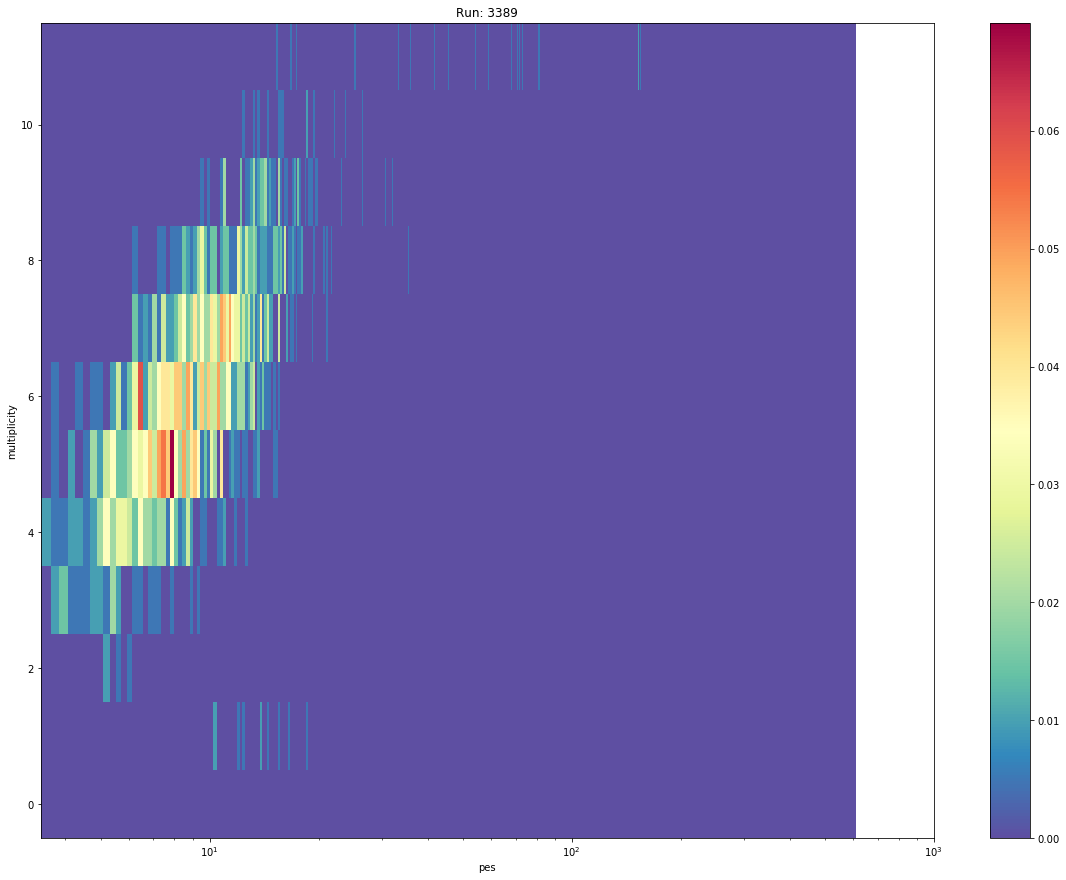

In [31]:
plot_mult_heatmap(energies, multiplicity.sum(axis=1))

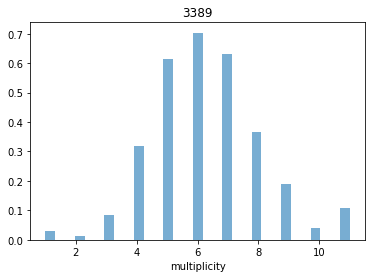

In [32]:
plt.hist(multiplicity.sum(axis=1), bins=30 + 1, alpha=0.6, normed=True)
plt.xlabel('multiplicity')
plt.title(str(run_number))
plt.show()